# 13 · Filtro Bilateral 


$$
BF[I]_p = \frac{1}{W_p} \sum_{q \in S} G_{\sigma_s}(\|p-q\|) \, G_{\sigma_r}(|I_p - I_q|) \, I_q,
$$

con factor de normalización

$$
W_p = \sum_{q \in S} G_{\sigma_s}(\|p-q\|) \, G_{\sigma_r}(|I_p - I_q|).
$$

- $G_{\sigma_s}(\|p-q\|)$ es el **término espacial**, que asigna más peso a los vecinos cercanos en la imagen.
- $G_{\sigma_r}(|I_p - I_q|)$ es el **término de rango**, que asigna más peso a píxeles con intensidad similar.

Así, un píxel $q$ contribuye mucho a $p$ sólo si es **cercano en espacio** y **parecido en intensidad**.


## 1) Parámetros de OpenCV: `cv2.bilateralFilter`

```python
dst = cv2.bilateralFilter(src, d, sigmaColor, sigmaSpace)
```

- **`d`**: diámetro de la ventana (si $d\leq 0$, se estima a partir de `sigmaSpace`).
- **`sigmaColor`** (→ $\sigma_r$): controla la mezcla entre intensidades distintas.
- **`sigmaSpace`** (→ $\sigma_s$): controla el alcance espacial de la vecindad.
- **Resultado:** suaviza ruido manteniendo bordes.


## 2) Carga de imagen y ruido

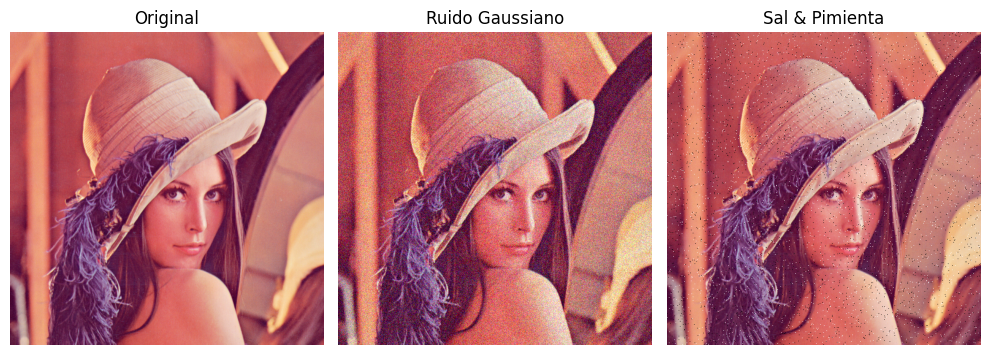

In [4]:
import cv2, numpy as np, matplotlib.pyplot as plt

IMG_PATH = r"C:\Users\rrm21\Documents\Vision_en_Robotica\imagenes\lenna.png"
img_bgr = cv2.imread(IMG_PATH)
if img_bgr is None:
    raise FileNotFoundError("No se pudo cargar la imagen.")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

def add_gaussian_noise(img, mean=0, sigma=25):
    noise = np.random.normal(mean, sigma, img.shape).astype(np.float32)
    out = img.astype(np.float32) + noise
    return np.clip(out, 0, 255).astype(np.uint8)

def add_salt_pepper(img, prob=0.02):
    noisy = img.copy()
    rnd = np.random.rand(*img.shape[:2])
    noisy[rnd < prob/2] = 0
    noisy[rnd > 1 - prob/2] = 255
    return noisy

img_gauss = add_gaussian_noise(img_rgb)
img_sp = add_salt_pepper(img_rgb)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(img_rgb); plt.title('Original'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(img_gauss); plt.title('Ruido Gaussiano'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(img_sp); plt.title('Sal & Pimienta'); plt.axis('off')
plt.tight_layout(); plt.show()

## 3) Aplicación del filtro bilateral

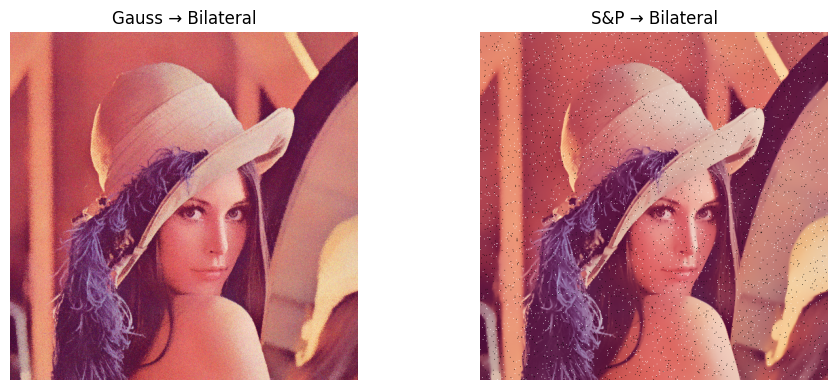

In [5]:
d, sigmaColor, sigmaSpace = 0, 50, 12
img_gauss_bilat = cv2.bilateralFilter(img_gauss, d, sigmaColor, sigmaSpace)
img_sp_bilat = cv2.bilateralFilter(img_sp, d, sigmaColor, sigmaSpace)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(img_gauss_bilat); plt.title('Gauss → Bilateral'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(img_sp_bilat); plt.title('S&P → Bilateral'); plt.axis('off')
plt.tight_layout(); plt.show()

## 4) Métricas de calidad (MSE, PSNR, SSIM)

In [6]:
def mse(a,b):
    return np.mean((a.astype(np.float32)-b.astype(np.float32))**2)

def psnr(a,b,L=255.0):
    m = mse(a,b)
    return 10*np.log10((L**2)/m)

def to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

from math import isfinite

orig_gray = to_gray(img_rgb)
g_bilat_gray = to_gray(img_gauss_bilat)
s_bilat_gray = to_gray(img_sp_bilat)

from skimage.metrics import structural_similarity as ssim

rows = []
rows.append(["Gauss→Bilateral", mse(img_rgb,img_gauss_bilat), psnr(img_rgb,img_gauss_bilat), ssim(orig_gray,g_bilat_gray)])
rows.append(["S&P→Bilateral", mse(img_rgb,img_sp_bilat), psnr(img_rgb,img_sp_bilat), ssim(orig_gray,s_bilat_gray)])

import pandas as pd
df = pd.DataFrame(rows, columns=['Caso','MSE','PSNR','SSIM'])
df

,Caso,MSE,PSNR,SSIM
0,Gauss→Bilateral,144.449326,26.533649,0.670183
1,S&P→Bilateral,407.880981,22.025469,0.541840
